In [1]:
import pandas as pd
import numpy as np

#modeling
from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from classification_functions import logistic_model, knn_classification, conf_matrix, plot_roc, decision_tree
from classification_functions import random_forest, multinomial_nb

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#set the rc parameters
plt.style.use('ggplot')
plt.rc('font', size=10)

Load data

In [3]:
df = pd.read_pickle('../Data/survey_data_cleaned2.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65636 entries, 4 to 56166
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Hobbyist                65636 non-null  object  
 1   Age                     65636 non-null  float64 
 2   Age1stCode              65636 non-null  float64 
 3   EdLevel                 65636 non-null  object  
 4   Ethnicity               65636 non-null  object  
 5   Gender                  65636 non-null  object  
 6   OpSys                   65636 non-null  category
 7   UndergradMajor          65636 non-null  object  
 8   YearsCode               65636 non-null  float64 
 9   YearsCodePro            65636 non-null  float64 
 10  database_count          65636 non-null  int64   
 11  Region                  65636 non-null  object  
 12  back-end                65636 non-null  object  
 13  full-stack              65636 non-null  object  
 14  front-end             

In [4]:
print(len(df))
df['OpSys'].value_counts()

65636


Windows        29878
MacOS          18368
Linux-based    17390
Name: OpSys, dtype: int64

### EDA

In [5]:
# We want to pick one feature to start that separates the two cases.
# sns.pairplot(df[['OpSys', 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'database_count']], 
#              corner=True, height=1.5, plot_kws={'size': 3}, hue='OpSys')

In [6]:
# categorical_columns = ['database_count', 'EdLevel', 'Ethnicity', 'Gender', 'UndergradMajor', 'Region']
# fig, ax =plt.subplots(3,2, gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=(15,15))
# idx = 0
# for x in range(0,3):
#     for y in range(0,2):
#         sns.countplot(x = categorical_columns[idx], hue='OpSys', data=df, ax=ax[x,y])
#         ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(),rotation=20)
#         idx= idx+1
# fig.show()

In [7]:
# binary_columns = ['Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 'Designer',
#                  'System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work',
#                  'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']
# fig, ax =plt.subplots(7,3, gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, figsize=(15,25))
# idx = 0
# for x in range(0,7):
#     for y in range(0,3):
#         if idx >= 19:
#             break
#         sns.countplot(x = binary_columns[idx], hue='OpSys', data=df, ax=ax[x,y])
#         idx= idx+1
# fig.show()

### Baseline Modeling

In [8]:
# X = df[['database_count', 'EdLevel', 'Ethnicity', 'Gender', 'UndergradMajor', 'Region', 
#         'Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
#         'Designer','System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work', 
#        'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
# do not include Age1stCode, YearsCodePro, ethnicity, hobbyist, other occupation, retired dev, sometimes code at work
X = df[['Age', 'YearsCode', 'database_count',
         'EdLevel', 'Gender', 'UndergradMajor', 'Region', 
         'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
        'Designer','System admin', 'Student', 
       'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
y = df['OpSys']

X=pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
#X.info()

Multinomial NB:

Accuracy: 0.5306,
Precision score: 0.5126000000000001,
Recall score: 0.47359999999999997,
f1 score: 0.4741999999999999,
fbeta score for beta = 0.1: 0.5114000000000001,
ROC AUC score: 0.6898,
Log-loss: 0.9718,



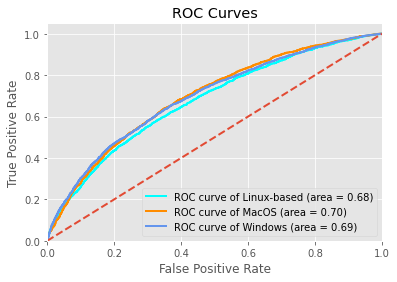

MultinomialNB()

In [9]:
multinomial_nb(X_train, y_train, b = 0.1)

Random Forest with 100 estimators:

Accuracy: 0.8238,
Precision score: 0.8248,
Recall score: 0.8090000000000002,
f1 score: 0.8155999999999999,
fbeta score for beta = 0.1: 0.8248,
ROC AUC score: 0.9384,
Log-loss: 0.5307999999999999,



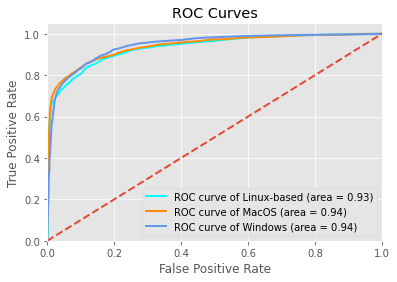

In [10]:
rf = random_forest(X_train, y_train, estimators = 100, b = 0.1)

Decision Tree with max depth of 6:

Accuracy: 0.5250000000000001,
Precision score: 0.5056,
Recall score: 0.4726,
f1 score: 0.472,
fbeta score for beta = 0.1: 0.5046,
ROC AUC score: 0.6834,
Log-loss: 0.9768000000000001,



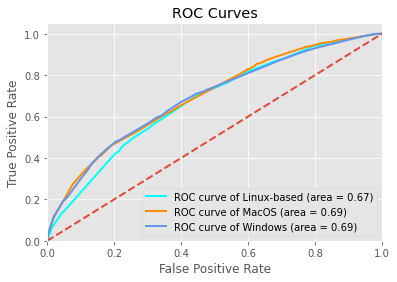

In [11]:
dt = decision_tree(X_train, y_train, depth = 6, b = 0.1)

logistic regression with C = 1:

Accuracy: 0.5476,
Precision score: 0.5264,
Recall score: 0.5014,
f1 score: 0.5046,
fbeta score for beta = 0.1: 0.526,
ROC AUC score: 0.7102,
Log-loss: 0.9475999999999999,



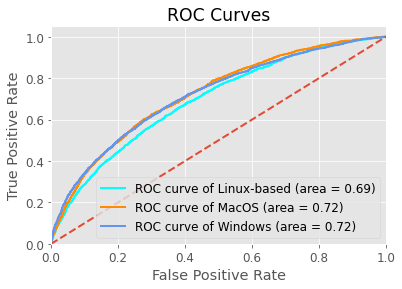

In [12]:
plt.rc('font', size=12)
lm = logistic_model(X_train, y_train, regularization = 1, threshold =  False, threshold_val = 0.5, b = 0.1)
#conf_matrix(lm_mn, X_test, y_test)

In [13]:
lm.coef_

array([[-1.08227295e-02,  1.14471637e-02,  2.03303100e-02,
         1.98095302e-02,  1.47056473e-01,  6.02586592e-01,
         9.66314155e-02,  1.13328694e-01,  2.23954960e-03,
        -1.85384952e-01,  2.26244906e-01,  3.65069287e-01,
         3.51735841e-01,  5.32626467e-01,  2.75620225e-01,
         2.69616686e-01,  3.31792113e-01,  1.45830812e-01,
         2.44864655e-01,  6.98735167e-02, -3.87052216e-01,
        -1.21751146e-01,  8.02171811e-02, -1.39504672e-01,
        -2.31306767e-01, -3.89697238e-01,  1.97666428e-01,
        -8.89984291e-02,  2.62630614e-01,  1.26780688e-02,
        -1.67154750e-01, -1.35529142e-01, -3.97152124e-01,
         1.04304965e-01,  6.04920927e-02, -9.37949713e-02,
         4.70692022e-01,  1.63359651e-01, -1.27754203e-01,
         4.80789661e-01, -2.49478662e-01,  3.74055199e-02,
        -8.07819294e-02],
       [ 1.23501147e-03, -1.52338984e-03,  8.37625604e-02,
         1.74823063e-01,  1.25615238e-01, -3.26710532e-01,
        -6.90461735e-02,  1.03

In [ ]:
knn = knn_classification(X_train, y_train, k = 5, b = 0.1)
#conf_matrix(knn, X_test, y_test)